In [2]:
#Based on the pytorch tutorial

#Importing torchvision
import torch
import torchvision
import torchvision.transforms as transforms

#setup batch size
batchS = 4

#Loading CIFAR10 and normalizing
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchS,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchS,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
#Checking what's inside of the loaders
print(trainloader.dataset)

print(testloader.dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


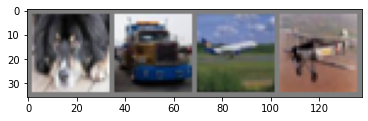

  dog truck plane plane


In [4]:
#Import for viewing data
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batchS)))

In [0]:
#Import for CNN definition
import torch.nn as nn
import torch.nn.functional as F

#Defining CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)   #convolutional
        self.pool = nn.MaxPool2d(2, 2)    #maxpooling
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #Linear
        self.fc2 = nn.Linear(120, 84)     
        self.fc3 = nn.Linear(84, 10)

#forward
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [0]:
#Import optimizer
import torch.optim as optim

#Defining loss function
criterion = nn.CrossEntropyLoss()
#Defining optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [15]:
#Training the network
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.301
[1,  4000] loss: 1.314
[1,  6000] loss: 1.272
[1,  8000] loss: 1.239
[1, 10000] loss: 1.248
[1, 12000] loss: 1.223
[2,  2000] loss: 1.141
[2,  4000] loss: 1.135
[2,  6000] loss: 1.152
[2,  8000] loss: 1.129
[2, 10000] loss: 1.152
[2, 12000] loss: 1.157
Finished Training


In [0]:
#Saving trained model, not necessary
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

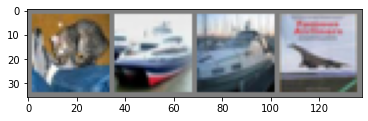

GroundTruth:    cat  ship  ship plane


In [17]:
#Testing CNN on test data

#setting up variables
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batchS)))

In [18]:
#Loading model, not necessary
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [19]:
#To check what the CNN thinks the outputs are
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batchS)))

Predicted:    cat  ship  ship plane


In [22]:
#Checking overall performance (how many correct/total)
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [23]:
#Checking each class performance

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 73 %
Accuracy of  bird : 52 %
Accuracy of   cat : 48 %
Accuracy of  deer : 49 %
Accuracy of   dog : 27 %
Accuracy of  frog : 77 %
Accuracy of horse : 69 %
Accuracy of  ship : 79 %
Accuracy of truck : 53 %
